In [76]:
import sys
import glob
import re
import math
import fnmatch
from os import listdir
from os.path import join, isfile, basename

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

import pandas
import cPickle as pickle

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# VFB labels and label names
labels = [16,64,8,32,2,4,65,66,33,67,34,17,69,70,35,71,9,18,72,36,73,74,37,75,19,76,38,77,39,78,79,20,5,40,80,10,81,82,83,84,85,86,11,22,23,24,12,3,6,49,50,25,51,13,52,26,53,27,54,55,56,28,7,14,57,58,29,59,30,60,15,61,31,62,63]
label_names_file = '/groups/saalfeld/home/bogovicj/vfb/DrosAdultBRAINdomains/refData/Original_Index.tsv'

label_names = pandas.read_csv( label_names_file, delimiter='\t', header=0 )
# print label_names[ label_names['Stack id'] == 11 ]['JFRCtempate2010.mask130819' ].iloc[0]
# print label_names[ label_names['Stack id'] == 70 ]['JFRCtempate2010.mask130819' ].iloc[0]

def get_label_name( label_id ):
    return label_names[ label_names['Stack id'] == label_id ]['JFRCtempate2010.mask130819' ].iloc[0]

# label_names['JFRCtempate2010.mask130819']

label_shorthand_col ='JFRCtempate2010.mask130819'
label_id_col ='Stack id'


# Find left-right matching labels
rnames = label_names[ label_names.apply( lambda x : x[label_shorthand_col].endswith('_R'), axis=1 )]

lr_pair_list = []
for rn in rnames.loc[:,label_shorthand_col]:
    ln = rn.replace('_R','_L')
    id_R = label_names[ label_names[label_shorthand_col]==rn ].loc[:,label_id_col]
    id_L = label_names[ label_names[label_shorthand_col]==ln ].loc[:,label_id_col]
    lr_pair_list += [[id_R.values[0], id_L.values[0]]]
lr_pair_list = np.array( lr_pair_list )
# print lr_pair_list

In [3]:
ids = np.unique( label_names.as_matrix( columns=['Stack id']))
print ids

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]


In [4]:
# Relevant directories

neuron_list_file="/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/prefix_list_by_neuron.txt"
f=open(neuron_list_file)
tmp=f.read().splitlines()
f.close()
neurons = [ n.split(' ') for n in tmp ]

print ' '
name1 = 'ants_jfrc2'
jfrcDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp'
print jfrcDir

name2 = 'ants-el-ag_owl'
grpDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp'
print grpDir

distDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/distComp'

names = [ name1, name2 ]
print names 

# jfrc_hist_sizes = pandas.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp/totals.csv', header=None, names=['pair','count'] )
# grp_hist_sizes = pandas.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp/totals.csv', header=None, names=['pair','count'] )


 
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp
['ants_jfrc2', 'ants-el-ag_owl']


In [5]:
# Functions

def flatten( list_of_lists ):
    return [ item for sublist in list_of_lists for item in sublist ]

def getCount( df_counts, pair_name ):
    res = df_counts[ df_counts.pair == pair_name ]['count']

def normalizeHistogram( hist ):
    hist[:,1] = hist[:,1]/np.sum( hist[:,1])
    return hist

def plotHistBar( hist, title ):
    x = hist[1:-1,0]
    y = hist[1:-1,1]
    plt.bar( x, y )
    plt.xlabel('Distance')
    plt.ylabel('Freq')
    plt.title( title )
    
def plotHistsTogether( hists, names ):
    for i in range( len( hists )):
        hist = hists[ i ]
        x = hist[1:-1,0]
        y = hist[1:-1,1]
        plt.plot( x, y )

    plt.xlabel('Distance')
    plt.ylabel('Freq')
    plt.legend( names )
    
def findHistCsv( folder, label, line ):
    testf = join( folder, 'combined__labelHist_{}_line{}.csv'.format( label, line ))
    if isfile( testf ):
        return testf
    else:
        print'could not find file for label {} and line {} in folder {}'.format( label, line, folder )
        return None
    
def findHistStatCsv( line_names, folder, label, line ):
    out = []
    for prefix in line_names[ line ]:
        pattern = '{}/{}*_labelHist_stats_{}.csv'.format(folder,prefix,label)
#         print pattern
        possibles = glob.glob( pattern )
        #print 'possibles ', possibles
        out += possibles
    return out

def findDistDataCsv( folder, label, line ):
    out = []
    pattern = '{}/combined__distXfmData_{}_line{}.csv'.format(folder,label, line)
#     print pattern
    possibles = glob.glob( pattern )
    #print 'possibles ', possibles
    out += possibles
    return out

def findCombinedDataCsv( folder, label, line ):
    out = []
    pattern = '{}/combined__labelData_{}_line{}.csv'.format(folder,label,line)
    possibles = glob.glob( pattern )
    out += possibles
    return out

def concatenateCentiles( centile_files, cent=0.5 ):
    out = np.array([[]])
    for f in centile_files:
        try:
            stats = genfromtxt( f, delimiter=',' )
            a = stats[1, np.argwhere(stats[0,:]==cent )]
            out = np.concatenate( (out,a), axis=1)
        except ValueError:
            continue
    return out

def getHistogramCounts( centile_files ):
    out = np.array([[]])

def cheap_hist_percentile( hist_in, percentile ):
    hist = hist_in[1:-1,:]
    total=np.sum(hist[:,1])
    cumsum=np.cumsum(hist[:,1])
    return hist[ cumsum > ( percentile * total ), 0 ][ 0 ]

def counts( df_pair_label_counts, names ):
    results = []
    for n in names: 
        pair=basename( n.replace('_stats_','_'))
#         print pair
        thiscount = df_pair_label_counts[ df_pair_label_counts[ 'pair' ] == pair ]['count']

        if thiscount.size != 1:
            continue

        results += [ thiscount.values ]
#         print results
        
    return np.mean( np.array( results ))



In [73]:
# grpDataFile = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp/combined__labelData_16_line1.csv'
# jrcDataFile = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp/combined__labelData_16_line1.csv'

# grpDataFile2 = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp/combined__labelData_63_line1.csv'
# jrcDataFile2 = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp/combined__labelData_63_line1.csv'

# grp_dat = genfromtxt( grpDataFile, delimiter=',' )
# jrc_dat = genfromtxt( jrcDataFile, delimiter=',' )

# grp_dat2 = genfromtxt( grpDataFile2, delimiter=',' )
# jrc_dat2 = genfromtxt( jrcDataFile2, delimiter=',' )

# # print grp_dat.shape
# # print jrc_dat.shape 
# # print grp_dat2.shape
# # print jrc_dat2.shape

# grp_dat = np.concatenate( (grp_dat,grp_dat2) )
# # print grp_dat.shape

In [46]:
# Load the data 
line = 1
sample_counts = {}

dist_all_data = {}
grp_all_data = {}
jrc_all_data = {}

sz =  None 
for l in labels:
    
#     print l

    if l in lr_pair_list:

#         print 'here'
        i,j =  np.where( lr_pair_list == l )
        jother = 0 if j==1 else 1
        label_pair = lr_pair_list[i,jother][0]
        
        if l < label_pair:
            
            jfrcDataFileList = findCombinedDataCsv( jfrcDir, l, line )
            grpDataFileList  = findCombinedDataCsv(  grpDir, l, line )
            
            grp_dat = genfromtxt( grpDataFileList[0], delimiter=',' )
            jrc_dat = genfromtxt( jfrcDataFileList[0], delimiter=',' )
            
            other_grpDataFileList  = findCombinedDataCsv(  grpDir, label_pair, line )
            other_jfrcDataFileList = findCombinedDataCsv( jfrcDir, label_pair, line )
            
#             print jfrcDataFileList[0]
#             print grpDataFileList[0]
            
#             print other_jfrcDataFileList[0]
#             print other_grpDataFileList[0]
            
            other_grp_dat = genfromtxt( other_grpDataFileList[0], delimiter=',' )
            other_jrc_dat = genfromtxt( other_jfrcDataFileList[0], delimiter=',' )
            
            
            # Get distance distribution
            dist_dat1 = genfromtxt( findDistDataCsv( distDir, l, line )[0], delimiter=',' )
            dist_dat2 = genfromtxt( findDistDataCsv( distDir, label_pair, line )[0], delimiter=',' )
            
            
            dist_all_data[ l ] = np.concatenate( ( dist_dat1, dist_dat2 )) 
            grp_all_data[ l ] = np.concatenate( (grp_dat, other_grp_dat ))
            jrc_all_data[ l ] = np.concatenate( (jrc_dat, other_jrc_dat ))
            
            dist_all_data[ label_pair ] = np.array([])
            grp_all_data[ label_pair ] = np.array([])
            jrc_all_data[ label_pair ] = np.array([])
            
            ng = len( grp_dat )
            nj = len( jrc_dat )
            sample_counts[ l ] =  ( nj + ng )
            sample_counts[ label_pair ] =  0
            
#             print sample_counts[ l ]
            
    else:
#         print 'face'
        jfrcDataFileList = findCombinedDataCsv( jfrcDir, l, line )
        grpDataFileList  = findCombinedDataCsv(  grpDir, l, line )

        grp_dat = genfromtxt( grpDataFileList[0], delimiter=',' )
        jrc_dat = genfromtxt( jfrcDataFileList[0], delimiter=',' )

        distDataF = findDistDataCsv( distDir, l, line )
        dist_all_data[ l ] = genfromtxt( distDataF[0], delimiter=',' )
        
        ng = len( grp_dat )
        nj = len( jrc_dat )

        grp_all_data[ l ] = grp_dat
        jrc_all_data[ l ] = jrc_dat
        sample_counts[ l ] =  ( nj + ng )
#         print sample_counts[ l ]

#     print ' '
    
# sample_counts
# print dist_all_data

In [74]:
# Decide on label ordering and compile x-labels

sorted_idxs  = np.argsort( np.array( sample_counts.values() ))
# print 'sorted_idxs:'
# print sorted_idxs
# print ' '

sorted_labels = np.array( sample_counts.keys())[ sorted_idxs ]
sorted_labels = list(reversed(sorted_labels))
print 'sorted_labels:'
print sorted_labels
print ' '


sorted_label_counts = np.array( sample_counts.values())[ sorted_idxs ]
sorted_label_counts = list(reversed(sorted_label_counts))
print 'sorted_label_counts:'
print sorted_label_counts
print ' '

# print lr_pair_list[ np.where( lr_pair_list == 86 )[0], : ]

ordered_labels = []
xlabels = []

# Pick xlabels based on size, but make sure left and right are adjacent
for l in sorted_labels:
    ordered_labels += [ l ]

# print ' '
# print ordered_labels

xlabels = flatten( [ [ '', str(get_label_name(l)).replace('_R',''), ''] for l in ordered_labels ] )
# print xlabels

sorted_labels:
[27, 33, 39, 12, 30, 25, 36, 49, 3, 14, 29, 9, 7, 31, 37, 35, 6, 22, 11, 18, 17, 15, 50, 19, 38, 34, 26, 40, 24, 32, 28, 13, 2, 8, 16, 20, 10, 4, 5, 23, 51, 77, 73, 74, 75, 76, 80, 78, 79, 81, 82, 83, 84, 72, 52, 71, 70, 53, 54, 85, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 86]
 
sorted_label_counts:
[184702, 128640, 119102, 97880, 84456, 80742, 61626, 48492, 44746, 40180, 32872, 30874, 27254, 23832, 23706, 21126, 15592, 12752, 10832, 8924, 8256, 7808, 5990, 5562, 3176, 2486, 2030, 2026, 1962, 1926, 1828, 1290, 908, 824, 800, 580, 196, 116, 64, 52, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 


{2: 0.07099296325254105, 3: 0.03324131414104195, 4: 0.006882230792049837, 5: 0.00749063670411985, 6: 0.32363319357383036, 7: 0.14235496288867647, 8: 0.006715785355675817, 9: 0.4147334202006905, 10: 0.013268345518548606, 11: 0.0924910770702051, 12: 0.4108134425142387, 13: 0.006624625118113471, 14: 0.262659013950083, 15: 0.1628838451268358, 16: 0.0032391811350090697, 17: 0.09973062102122417, 18: 0.09061738424045492, 19: 0.02766063258404615, 20: 0.006516634270754919, 22: 0.015144263599494083, 23: 0.0007068290561113527, 24: 0.003250276240348154, 25: 0.01852190848467748, 26: 0.00916329625884732, 27: 0.29580622739837475, 28: 0.010270528415315897, 29: 0.05286187760011707, 30: 0.09386847343694255, 31: 0.059832342906206926, 32: 0.010659847906219905, 33: 0.27973183667522705, 34: 0.018654280504551014, 35: 0.36055501510419335, 36: 0.3118945674288664, 37: 0.05172323509133277, 38: 0.008339087899132746, 39: 0.5353428204137038, 40: 0.056865386774447066, 49: 0.03956379633603282, 50: 0.05949661296410338

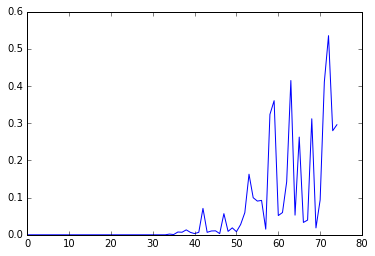

In [91]:
comp_sizes = pickle.load( open( "comp_sizes.p", "rb"))
# print comp_sizes

fraction_of_compartment_sampled = {}

for l in labels:
    
    if l in lr_pair_list:

        i,j =  np.where( lr_pair_list == l )
        jother = 0 if j==1 else 1
        label_pair = lr_pair_list[i,jother][0]
        
        if l < label_pair:
            # This merges left and right into the label with the lower index
            fraction_of_compartment_sampled[ l ] = sample_counts[ l ] / ( 1.0 * comp_sizes[ l ] + comp_sizes[ label_pair ] )
            fraction_of_compartment_sampled[ label_pair ] = 0

    else:
        fraction_of_compartment_sampled[ l ] =  sample_counts[ l ] / ( 1.0 * comp_sizes[ l ] )


print fraction_of_compartment_sampled
print ' '
print len( fraction_of_compartment_sampled.values() )

sortedBysize_fraction_comp_sampled = np.array( fraction_of_compartment_sampled.values())[ sorted_idxs ]

plt.plot( sortedBysize_fraction_comp_sampled )

12752
10832


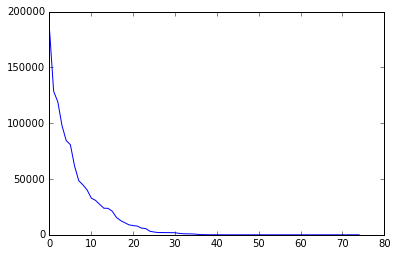

In [16]:
plt.plot( sorted_label_counts )

N = 17

print sorted_label_counts[ N ]
print sorted_label_counts[ N + 1 ]

In [42]:
# make the sorted data set

# print grp_all_data[27].shape
# print jrc_all_data[27].shape

xpositions = []
small_space = 3
big_space = 6
p = 1

all_data = []
for l in ordered_labels:
    all_data += [ jrc_all_data[ l ] ]
    all_data += [ grp_all_data[ l ] ]
    all_data += [ dist_all_data[ l ] ]
    
    xpositions += [ p, p + small_space, p + 2*small_space ]
    p += ( big_space + 2*small_space )

# print xpositions
    
# bp = plt.boxplot( all_data, positions=xpositions, whis=2.5, showfliers=False )

# c1 = '#226078'
# c2 = '#910033'
# even = True
# for box in bp['boxes']:
#     if even:
#         box.set( color=c1, linewidth=1)
#     else:
#         box.set( color=c2, linewidth=1)
#     even = not even

# i = 0
# for w in bp['whiskers']:
#     if i == 0 or i == 1:
#         w.set( color=c1, linewidth=0.5, linestyle='-')
#     else:
#         w.set( color=c2, linewidth=0.5, linestyle='-')
#     i += 1
    
#     if i == 4: 
#         i = 0
    
# even = True
# for m in bp['medians']:
#     if even:
#         m.set( color=c1, linewidth=1)
#     else:
#         m.set( color=c2, linewidth=1)
#     even = not even

# for c in bp['caps']:
#     c.set_visible( False )
    
# even = True
# for flier in bp['fliers']:
# #     flier.set_visible( False )
#     if even:
#         flier.set(marker='.', markeredgecolor=c1, markerfacecolor=c1, markersize=1, alpha=0.2 )
#     else:
#         flier.set(marker='.', markeredgecolor=c2, markerfacecolor=c2, markersize=1, alpha=0.2 )
#     even = not even

# plt.legend( names )

# ax = plt.gca()
# ax.set_xticklabels( xlabels )
# a = plt.setp( ax.get_xticklabels(), rotation=45, fontsize=8 )

# fig = plt.gcf()
# a = fig.set_size_inches( 16, 5 )

# plt.savefig('/nrs/saalfeld/john/projects/flyChemStainAtlas/biic_poster_figs/all_data_byLabel.svg')

In [18]:

def color_boxplot_by_group( bp, groups, colors ):
    for box,i in zip( bp['boxes'], np.arange(len( bp['boxes']))):
        box.set( color=colors[groups[i]])
    
    for med,i in zip( bp['medians'], np.arange(len( bp['medians']))):
#         med.set( color=colors[groups[i]])
        med.set( color='k')
        
    # repeat because there are two whiskers for each box
    for wskr,i in zip(  bp['whiskers'], np.repeat( np.array(groups), 2, axis = 0 ) ):
        wskr.set( color=colors[groups[i]])

def set_ticklabel_size( ax, size ):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize( size )
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize( size )

In [20]:
some_data = all_data[0: 2*N]
some_xpositions = xpositions[0: 2*N]

groups = np.tile( np.array([0,1,2]), len(some_data)/2 )
print groups 

[0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2]


some data is len 51 
 
[1, 4, 7, 13, 16, 19, 25, 28, 31, 37, 40, 43, 49, 52, 55, 61, 64, 67, 73, 76, 79, 85, 88, 91, 97, 100, 103, 109, 112, 115, 121, 124, 127, 133, 136, 139, 145, 148, 151, 157, 160, 163, 169, 172, 175, 181, 184, 187, 193, 196, 199]
[0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2]


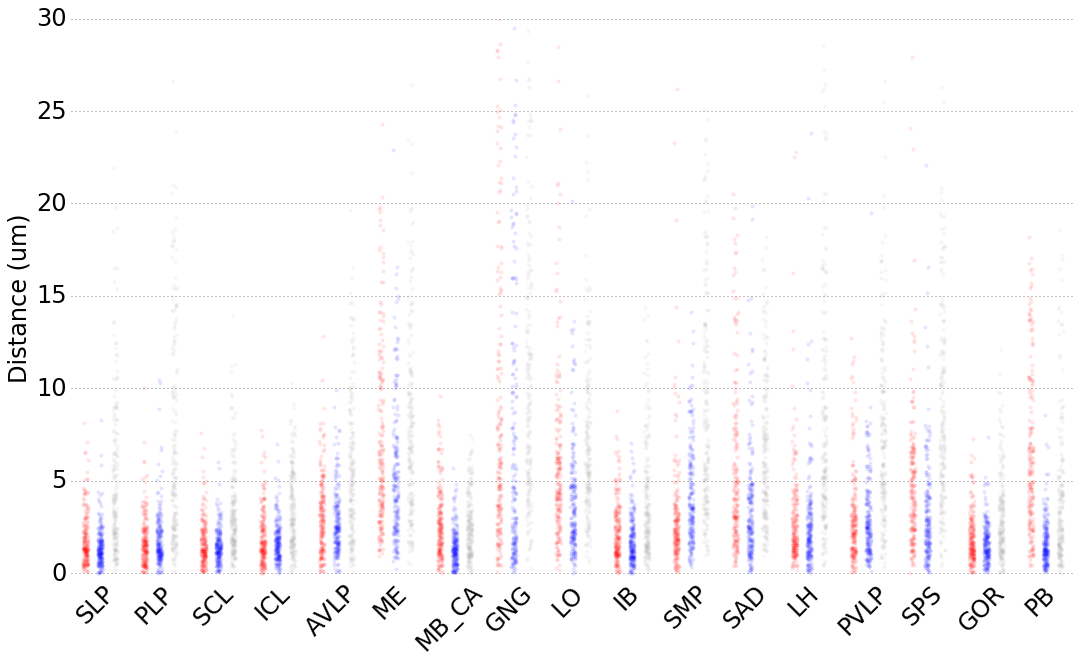

In [110]:

# some_data = all_data[0:6]
# some_xpositions = xpositions[0:6]
# groups = [0,1,0,1,0,1]

# some_data = all_data
# some_xpositions = xpositions

some_data = all_data[0: 3*N]
some_xpositions = xpositions[0: 3*N]


# print 'some data is len {} '.format( len( some_data ))
# print ' '
# print some_xpositions 

do_boxplot = False


# colors = ['#226078','#910033']
# colors = ['#ff9400','#540ead', '#0b5fa5']
colors = ['#ff0000','#0000ff', '#aaaaaa']
whisker_props = { 'linewidth' : 0.75, 'linestyle' : '-'}
box_props = { 'linewidth' : 1.4 }
med_props = { 'linewidth' : 1.4 }


max_scatter_pts = 200
scatter_radius = 1.0
y_scatter_radius = 1.0

if do_boxplot:
    bp = plt.boxplot( some_data, positions=some_xpositions, whis=2, showcaps=False, showfliers=False,
                boxprops=box_props, whiskerprops=whisker_props, medianprops=med_props )

for i in range( len( some_data )):
    if( len(some_data[ i ]) <= max_scatter_pts ):
        sample = some_data[ i ]
    else:
        sample = some_data[ i ][ np.random.choice( len(some_data[i]), max_scatter_pts)]
    
    x = np.repeat( (1 + some_xpositions[i]), len( sample ))
    x = x + ( scatter_radius * np.random.rand( *x.shape ) - (scatter_radius / 2) )
    
    sample = sample + ( y_scatter_radius * np.random.rand( *sample.shape ) - ( y_scatter_radius / 2.) )
    
    # make sure everything is above zero
    sample[ sample < 0 ] = -sample[ sample < 0 ]

    c = colors[ groups[i]]    
    plt.plot( x, sample, linestyle='None', marker='o', markersize=4, markeredgewidth=0,
             markerfacecolor=c, alpha=0.1 )
#     break

maxx = math.ceil( x[-1] + 1 )

ax = plt.gca()

# Turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Turn off tick markers
plt.tick_params( axis='x', bottom='off' )
plt.tick_params( axis='y', left='off' )

plt.gca().set_xlim([-1,maxx + 1])
plt.gca().set_ylim([-0.2,30])

plt.xticks( some_xpositions, xlabels, rotation=45, fontsize=24 )

if do_boxplot:
    color_boxplot_by_group( bp, groups, colors )

fig = plt.gcf()
_ = fig.set_size_inches( 18, 10 )

ax.yaxis.grid(True)
plt.ylabel( 'Distance (um)', fontsize=24 )

set_ticklabel_size( ax, 24 )

if do_boxplot:
    plt.savefig('/nrs/saalfeld/john/projects/flyChemStainAtlas/biic_poster_figs/lrmerge_wDist_line1_box-scatter-plot-style3.svg')
else:
    plt.savefig('/nrs/saalfeld/john/projects/flyChemStainAtlas/biic_poster_figs/lrmerge_wDist_line1_scatter-plot-style3.svg')